## **PIP install**

In [ ]:
!pip install segmentation_models_pytorch
!pip install sklearn
!pip install madgrad

## **Import modules and Packages**

In [80]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

import albumentations as A
from albumentations import RandomResizedCrop
from albumentations.augmentations.crops.transforms import RandomCrop
from albumentations.augmentations.geometric.rotate import RandomRotate90
from albumentations.augmentations.transforms import HorizontalFlip, VerticalFlip
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from pytorch_toolbelt import losses

from sklearn.model_selection import GroupKFold, KFold

from torch.cuda.amp import autocast, GradScaler

import madgrad

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors
%matplotlib inline

plt.rcParams['axes.grid'] = False

print('Pytorch version: {}'.format(torch.__version__))
print('GPU: {}'.format(torch.cuda.is_available()))

print('Device name: ', torch.cuda.get_device_name(0))
print('Device count: ', torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

Pytorch version: 1.9.1+cu102
GPU: True
Device name:  Tesla V100-SXM2-32GB
Device count:  1


In [81]:
!nvidia-smi

Thu Oct 21 14:49:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   39C    P0    52W / 300W |  20925MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Set Configs**

In [82]:
CFG = {
    'batch_size':16,
    'num_epochs':30,
    'lr':1e-4,
    'seed':21,
    'n_classes':11,
    'num_workers':0,
    'experiment_number':'1022',
    'encoder_model':'tu_xception41'
}

## **Utils**

In [83]:
import numpy as np

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(n_class * label_true[mask].astype(int) + label_pred[mask],
                        minlength=n_class ** 2).reshape(n_class, n_class) 
    return hist


def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc, iu


def add_hist(hist, label_trues, label_preds, n_class):
    """
        stack hist(confusion matrix)
    """

    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)

    return hist


def seed_everythind(seed):
    """
        Fix seed
    """
    random_seed = seed
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)


class_colormap = pd.read_csv("../class_dict.csv")
class_colormap

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [84]:
seed_everythind(CFG['seed'])

## **Define Dataframe(df)**

In [85]:
dataset_path  = '../../input'
train_path = dataset_path + '/train_all.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

def data_frame(anns_file_path): # for psudo
    with open(anns_file_path, 'r') as f:
        dataset = json.loads(f.read())
    
    categories = dataset['categories']
    anns = dataset['annotations']
    imgs = dataset['images']

    nr_cats = len(categories)
    nr_annotations = len(anns)
    nr_images = len(imgs)

    # Load categories and super categories
    cat_names = []
    super_cat_names = []
    super_cat_ids = {}
    super_cat_last_name = ''
    nr_super_cats = 0
    for cat_it in categories:
        cat_names.append(cat_it['name'])
        super_cat_name = cat_it['supercategory']
        # Adding new supercat
        if super_cat_name != super_cat_last_name:
            super_cat_names.append(super_cat_name)
            super_cat_ids[super_cat_name] = nr_super_cats
            super_cat_last_name = super_cat_name
            nr_super_cats += 1

    # Count annotations
    cat_histogram = np.zeros(nr_cats,dtype=int)
    for ann in anns:
        cat_histogram[ann['category_id']-1] += 1

    # Initialize the matplotlib figure

    # Convert to DataFrame
    df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
    df = df.sort_values('Number of annotations', 0, False)
    return df


# df_t = data_frame(anns_file_path)
# df_p = data_frame(psud_file_path)

# df = pd.concat([df_t, df_p], ignore_index=True)
# df = pd.DataFrame()
# for dataframe, colums in df_p:
#     if dataframe in df_t['Categories']:
#         df.append()
# category labeling 
df = data_frame(train_path)
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,2782.0
2,Paper,9311.0
3,Paper pack,659.0
4,Metal,562.0
5,Glass,610.0
6,Plastic,3090.0
7,Styrofoam,1343.0
8,Plastic bag,7643.0
9,Battery,63.0


## **CustomDataLoader**

In [86]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## **Dataset and Dataloader**

In [87]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [88]:
def get_augmentation(data_dir):
    if data_dir == 'train':
        return A.Compose([
                        A.OneOf([
                                A.GridDistortion(p=1.0),
                                A.RandomGridShuffle(p=1.0),
                                A.RandomResizedCrop(height=512, width=512, p=1.0),
                                A.HorizontalFlip(p=1.0),
                                A.VerticalFlip(p=1.0),                                
                                ], p=1.0),
                        A.RandomRotate90(p=1.0),
                        A.Cutout(p=0.75),
                        ToTensorV2()
                        ], p=1.0)
    else:
        return A.Compose([
                        ToTensorV2()
                        ], p=1.0)

In [89]:
test_path = dataset_path + '/test.json'

test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=get_augmentation('test'))
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=CFG['batch_size'], num_workers=0, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## **Define Model**

In [90]:
model = smp.create_model(
    arch="DeepLabV3Plus",
    encoder_name="tu-xception41",
    encoder_weights="swsl",
    in_channels=3,
    classes=11
).to(device)

### **Model Test**

In [93]:
x = torch.randn([2, 3, 512, 512]).to(device)
out = model(x)
print(f"input shape : {x.shape} | output shape : {out.size()}")

input shape : torch.Size([2, 3, 512, 512]) | output shape : torch.Size([2, 11, 512, 512])


## **One Epoch**

In [104]:
def train_one(epoch, model, train_loader, criterion, optimizer, scheduler, device):
    print(f'Start training..')

    model.train()
    hist = np.zeros((CFG['n_classes'], CFG['n_classes']))

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)

    for step, (images, masks, _) in pbar:

        images = torch.stack(images).float()       
        masks = torch.stack(masks).long() 
        
        # to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Autocast
        with autocast():
            model = model.to(device)
            
            # inference
            outputs = model(images)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        masks = masks.detach().cpu().numpy()
        
        hist = add_hist(hist, masks, outputs, n_class=CFG['n_classes'])
        mIoU = label_accuracy_score(hist)[2]

        description = f'epoch {epoch} Loss: {loss.item():.4f} mIoU: {round(mIoU,4)}'
        pbar.set_description(description)
            
    scheduler.step()

In [105]:
def val_one(epoch, model, val_loader, criterion, device):
    print(f'Start validation #{epoch}')

    model.eval()
    hist = np.zeros((CFG['n_classes'], CFG['n_classes']))

    total_loss = 0
    cnt = 0

    pbar = tqdm(enumerate(val_loader), total=len(val_loader), position=0, leave=True)

    for step, (images, masks, _) in pbar:
        
        images = torch.stack(images)       
        masks = torch.stack(masks).long() 
        
        # to device
        images = images.to(device)
        masks = masks.to(device)
        model = model.to(device)

        # inference
        outputs = model(images)

        loss = criterion(outputs, masks)
        total_loss += loss
        cnt += 1

        outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        masks = masks.detach().cpu().numpy()
        
        hist = add_hist(hist, masks, outputs, n_class=CFG['n_classes'])

        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]
        
        avg_loss = total_loss / cnt

        description = f'Validation #{epoch}  Average Loss: {round(avg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                    mIoU: {round(mIoU, 4)}'
        pbar.set_description(description)  
    print(f'IoU by class : {IoU_by_class}')
              
    return avg_loss, mIoU


## **Make Save dir**

In [96]:
saved_dir = '../saved/' + CFG['experiment_number']

if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name=CFG['experiment_number']+CFG['encoder_model']+'.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## **Define Loss and Optimizer**

In [97]:
criterion = losses.SoftCrossEntropyLoss()
optimizer = madgrad.MADGRAD(
    params = model.parameters(),
    lr = CFG['lr'],
    weight_decay = 1e-6)
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=CFG['num_epochs'],
    T_mult=1    
)

## **Folds**(not finished)

dataset_all = CustomDataLoader(data_dir=dataset_path + '/train_all.json',mode='train',transform=None)

from sklearn.model_selection import StratifiedKFold

FOLDS = 5
sorted_df["Folds"] = 0

def getDataloader(dataset, train_idx, valid_idx, batch_size=CFG['batch_size'], num_workers=CFG['num_workers']):
    train_set = torch.utils.data.Subset(dataset, indices=train_idx)
    valid_set = torch.utils.data.Subset(dataset, indices=valid_idx)

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=CFG['batch_size'], shuffle=True, num_workers=0, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=CFG['batch_size'], shuffle=False, num_workers=0, collate_fn=collate_fn)

    return train_loader, val_loader

skf = StratifiedKFold(n_splits=FOLDS)
for fold, (train_idx, valid_idx) in enumerate(skf.split(sorted_df,sorted_df['Folds'])):
    train_loader, valid_loader = getDataloader(dataset_all, train_idx, valid_idx)

## **Train**

In [109]:
for fold in range(5):
    print(f'{fold+1} fold start')
    scaler = GradScaler()

    train_path = dataset_path + '/train.json'
    val_path = dataset_path + '/val.json'

    train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=get_augmentation('train'))
    val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=get_augmentation('val'))
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=CFG['batch_size'], shuffle=True, num_workers=0, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=CFG['batch_size'], shuffle=False, num_workers=0, collate_fn=collate_fn)

    best_mIoU = 0

    for epoch in range(CFG['num_epochs']):
        train_one(epoch, model, train_loader, criterion, optimizer, scheduler, device)

        with torch.no_grad():
            epoch_loss, mIoU = val_one(epoch, model, val_loader, criterion, device)
        
        if best_mIoU < mIoU:
            best_mIoU = mIoU
            save_model(
                model,
                saved_dir,
                file_name=f"{CFG['experiment_number']}_{CFG['encoder_model']}_{fold}.pt")
            print('model is saved')
            
torch.cuda.empty_cache()


1 fold start
loading annotations into memory...
Done (t=5.55s)
creating index...
index created!
loading annotations into memory...


  0%|          | 0/164 [00:00<?, ?it/s]

Done (t=0.86s)
creating index...
index created!
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #0


Validation #0  Average Loss: 0.2622, Accuracy : 0.9205,                     mIoU: 0.5364: 100%|██████████| 41/41 [00:19<00:00,  2.43it/s]


IoU by class : [{'Backgroud': 0.9481}, {'General trash': 0.3665}, {'Paper': 0.7204}, {'Paper pack': 0.5123}, {'Metal': 0.4943}, {'Glass': 0.5447}, {'Plastic': 0.4262}, {'Styrofoam': 0.6083}, {'Plastic bag': 0.8021}, {'Battery': 0.0}, {'Clothing': 0.478}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #1


Validation #1  Average Loss: 0.2755, Accuracy : 0.9184,                     mIoU: 0.5635: 100%|██████████| 41/41 [00:19<00:00,  2.43it/s]


IoU by class : [{'Backgroud': 0.9456}, {'General trash': 0.42}, {'Paper': 0.7208}, {'Paper pack': 0.4102}, {'Metal': 0.4326}, {'Glass': 0.5336}, {'Plastic': 0.3812}, {'Styrofoam': 0.6453}, {'Plastic bag': 0.8096}, {'Battery': 0.3509}, {'Clothing': 0.5489}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #2


Validation #2  Average Loss: 0.2697, Accuracy : 0.92,                     mIoU: 0.5699: 100%|██████████| 41/41 [00:18<00:00,  2.51it/s]


IoU by class : [{'Backgroud': 0.9503}, {'General trash': 0.3705}, {'Paper': 0.7276}, {'Paper pack': 0.3111}, {'Metal': 0.4761}, {'Glass': 0.495}, {'Plastic': 0.4379}, {'Styrofoam': 0.6409}, {'Plastic bag': 0.8013}, {'Battery': 0.6409}, {'Clothing': 0.4172}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #3


Validation #3  Average Loss: 0.2511, Accuracy : 0.9254,                     mIoU: 0.602: 100%|██████████| 41/41 [00:19<00:00,  2.49it/s]


IoU by class : [{'Backgroud': 0.9517}, {'General trash': 0.4095}, {'Paper': 0.738}, {'Paper pack': 0.5258}, {'Metal': 0.5193}, {'Glass': 0.54}, {'Plastic': 0.4127}, {'Styrofoam': 0.6317}, {'Plastic bag': 0.8168}, {'Battery': 0.5783}, {'Clothing': 0.4984}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #4


Validation #4  Average Loss: 0.2526, Accuracy : 0.9258,                     mIoU: 0.6114: 100%|██████████| 41/41 [00:20<00:00,  2.30it/s]


IoU by class : [{'Backgroud': 0.9514}, {'General trash': 0.3895}, {'Paper': 0.7254}, {'Paper pack': 0.4657}, {'Metal': 0.4679}, {'Glass': 0.6201}, {'Plastic': 0.4521}, {'Styrofoam': 0.6723}, {'Plastic bag': 0.8206}, {'Battery': 0.6067}, {'Clothing': 0.554}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #5


Validation #5  Average Loss: 0.2597, Accuracy : 0.9242,                     mIoU: 0.5819: 100%|██████████| 41/41 [00:20<00:00,  2.47it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9518}, {'General trash': 0.3944}, {'Paper': 0.7163}, {'Paper pack': 0.3952}, {'Metal': 0.4968}, {'Glass': 0.4635}, {'Plastic': 0.4279}, {'Styrofoam': 0.6662}, {'Plastic bag': 0.8193}, {'Battery': 0.6035}, {'Clothing': 0.4661}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #6


Validation #6  Average Loss: 0.2587, Accuracy : 0.9256,                     mIoU: 0.582: 100%|██████████| 41/41 [00:19<00:00,  2.52it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9512}, {'General trash': 0.4104}, {'Paper': 0.7305}, {'Paper pack': 0.4524}, {'Metal': 0.496}, {'Glass': 0.5769}, {'Plastic': 0.4282}, {'Styrofoam': 0.6709}, {'Plastic bag': 0.8246}, {'Battery': 0.4227}, {'Clothing': 0.4385}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #7


Validation #7  Average Loss: 0.2569, Accuracy : 0.9286,                     mIoU: 0.6277: 100%|██████████| 41/41 [00:20<00:00,  2.45it/s]


IoU by class : [{'Backgroud': 0.9516}, {'General trash': 0.4263}, {'Paper': 0.7326}, {'Paper pack': 0.5246}, {'Metal': 0.5293}, {'Glass': 0.6437}, {'Plastic': 0.4658}, {'Styrofoam': 0.6709}, {'Plastic bag': 0.8212}, {'Battery': 0.6928}, {'Clothing': 0.4456}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #8


Validation #8  Average Loss: 0.2694, Accuracy : 0.9235,                     mIoU: 0.5954: 100%|██████████| 41/41 [00:18<00:00,  2.47it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9497}, {'General trash': 0.4135}, {'Paper': 0.7349}, {'Paper pack': 0.4178}, {'Metal': 0.3677}, {'Glass': 0.5682}, {'Plastic': 0.4205}, {'Styrofoam': 0.6688}, {'Plastic bag': 0.8176}, {'Battery': 0.6504}, {'Clothing': 0.5406}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #9


Validation #9  Average Loss: 0.2682, Accuracy : 0.9262,                     mIoU: 0.612: 100%|██████████| 41/41 [00:18<00:00,  2.47it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9524}, {'General trash': 0.4211}, {'Paper': 0.7341}, {'Paper pack': 0.5442}, {'Metal': 0.5074}, {'Glass': 0.5896}, {'Plastic': 0.443}, {'Styrofoam': 0.6419}, {'Plastic bag': 0.814}, {'Battery': 0.6248}, {'Clothing': 0.4593}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #10


Validation #10  Average Loss: 0.2476, Accuracy : 0.9304,                     mIoU: 0.6308: 100%|██████████| 41/41 [00:19<00:00,  2.45it/s]


IoU by class : [{'Backgroud': 0.9541}, {'General trash': 0.4088}, {'Paper': 0.7522}, {'Paper pack': 0.5361}, {'Metal': 0.5171}, {'Glass': 0.6565}, {'Plastic': 0.4266}, {'Styrofoam': 0.6771}, {'Plastic bag': 0.8295}, {'Battery': 0.5855}, {'Clothing': 0.5953}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #11


Validation #11  Average Loss: 0.2786, Accuracy : 0.9227,                     mIoU: 0.5913: 100%|██████████| 41/41 [00:19<00:00,  2.46it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.949}, {'General trash': 0.4123}, {'Paper': 0.7201}, {'Paper pack': 0.5096}, {'Metal': 0.5082}, {'Glass': 0.5272}, {'Plastic': 0.4472}, {'Styrofoam': 0.6279}, {'Plastic bag': 0.8162}, {'Battery': 0.5524}, {'Clothing': 0.4349}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #12


Validation #12  Average Loss: 0.2564, Accuracy : 0.9304,                     mIoU: 0.629: 100%|██████████| 41/41 [00:18<00:00,  2.38it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9531}, {'General trash': 0.4244}, {'Paper': 0.7322}, {'Paper pack': 0.4712}, {'Metal': 0.5381}, {'Glass': 0.6232}, {'Plastic': 0.46}, {'Styrofoam': 0.6951}, {'Plastic bag': 0.8373}, {'Battery': 0.6482}, {'Clothing': 0.5367}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #13


Validation #13  Average Loss: 0.2626, Accuracy : 0.9278,                     mIoU: 0.627: 100%|██████████| 41/41 [00:19<00:00,  2.38it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9521}, {'General trash': 0.412}, {'Paper': 0.7296}, {'Paper pack': 0.516}, {'Metal': 0.5271}, {'Glass': 0.6321}, {'Plastic': 0.4409}, {'Styrofoam': 0.6526}, {'Plastic bag': 0.8384}, {'Battery': 0.645}, {'Clothing': 0.5508}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #14


Validation #14  Average Loss: 0.2515, Accuracy : 0.93,                     mIoU: 0.636: 100%|██████████| 41/41 [00:19<00:00,  2.36it/s]


IoU by class : [{'Backgroud': 0.9536}, {'General trash': 0.4389}, {'Paper': 0.7441}, {'Paper pack': 0.572}, {'Metal': 0.5323}, {'Glass': 0.6022}, {'Plastic': 0.4573}, {'Styrofoam': 0.6827}, {'Plastic bag': 0.8277}, {'Battery': 0.6996}, {'Clothing': 0.4852}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #15


Validation #15  Average Loss: 0.257, Accuracy : 0.931,                     mIoU: 0.6365: 100%|██████████| 41/41 [00:19<00:00,  2.37it/s]


IoU by class : [{'Backgroud': 0.9556}, {'General trash': 0.4183}, {'Paper': 0.7389}, {'Paper pack': 0.5563}, {'Metal': 0.5477}, {'Glass': 0.6557}, {'Plastic': 0.4589}, {'Styrofoam': 0.6811}, {'Plastic bag': 0.8356}, {'Battery': 0.6518}, {'Clothing': 0.5018}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #16


Validation #16  Average Loss: 0.2538, Accuracy : 0.9323,                     mIoU: 0.6411: 100%|██████████| 41/41 [00:20<00:00,  2.13it/s]


IoU by class : [{'Backgroud': 0.9561}, {'General trash': 0.4116}, {'Paper': 0.7452}, {'Paper pack': 0.5796}, {'Metal': 0.5318}, {'Glass': 0.6423}, {'Plastic': 0.4689}, {'Styrofoam': 0.6786}, {'Plastic bag': 0.8333}, {'Battery': 0.6858}, {'Clothing': 0.5194}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #17


Validation #17  Average Loss: 0.2463, Accuracy : 0.9323,                     mIoU: 0.6404: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9565}, {'General trash': 0.4393}, {'Paper': 0.7436}, {'Paper pack': 0.5787}, {'Metal': 0.5614}, {'Glass': 0.6388}, {'Plastic': 0.463}, {'Styrofoam': 0.6652}, {'Plastic bag': 0.8335}, {'Battery': 0.6467}, {'Clothing': 0.5178}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #18


Validation #18  Average Loss: 0.2486, Accuracy : 0.9338,                     mIoU: 0.6443: 100%|██████████| 41/41 [00:19<00:00,  2.45it/s]


IoU by class : [{'Backgroud': 0.9579}, {'General trash': 0.434}, {'Paper': 0.7545}, {'Paper pack': 0.5507}, {'Metal': 0.5752}, {'Glass': 0.622}, {'Plastic': 0.4602}, {'Styrofoam': 0.6803}, {'Plastic bag': 0.8377}, {'Battery': 0.6784}, {'Clothing': 0.5365}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #19


Validation #19  Average Loss: 0.248, Accuracy : 0.9328,                     mIoU: 0.6394: 100%|██████████| 41/41 [00:19<00:00,  2.36it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9576}, {'General trash': 0.4321}, {'Paper': 0.7479}, {'Paper pack': 0.5439}, {'Metal': 0.5412}, {'Glass': 0.6423}, {'Plastic': 0.464}, {'Styrofoam': 0.6796}, {'Plastic bag': 0.8375}, {'Battery': 0.6307}, {'Clothing': 0.5565}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #20


Validation #20  Average Loss: 0.2477, Accuracy : 0.9349,                     mIoU: 0.6495: 100%|██████████| 41/41 [00:19<00:00,  2.47it/s]


IoU by class : [{'Backgroud': 0.9577}, {'General trash': 0.4274}, {'Paper': 0.753}, {'Paper pack': 0.5742}, {'Metal': 0.5565}, {'Glass': 0.6448}, {'Plastic': 0.4777}, {'Styrofoam': 0.6955}, {'Plastic bag': 0.8402}, {'Battery': 0.6532}, {'Clothing': 0.5638}]


  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #21


Validation #21  Average Loss: 0.2484, Accuracy : 0.9334,                     mIoU: 0.6438: 100%|██████████| 41/41 [00:18<00:00,  2.43it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9574}, {'General trash': 0.4248}, {'Paper': 0.7589}, {'Paper pack': 0.5573}, {'Metal': 0.5639}, {'Glass': 0.6409}, {'Plastic': 0.461}, {'Styrofoam': 0.6804}, {'Plastic bag': 0.8392}, {'Battery': 0.6363}, {'Clothing': 0.5618}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #22


Validation #22  Average Loss: 0.2492, Accuracy : 0.9329,                     mIoU: 0.6366: 100%|██████████| 41/41 [00:18<00:00,  2.42it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9574}, {'General trash': 0.4156}, {'Paper': 0.7554}, {'Paper pack': 0.5727}, {'Metal': 0.5435}, {'Glass': 0.6304}, {'Plastic': 0.4619}, {'Styrofoam': 0.6836}, {'Plastic bag': 0.8372}, {'Battery': 0.5895}, {'Clothing': 0.555}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #23


Validation #23  Average Loss: 0.2456, Accuracy : 0.9334,                     mIoU: 0.644: 100%|██████████| 41/41 [00:19<00:00,  2.46it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9576}, {'General trash': 0.4221}, {'Paper': 0.7511}, {'Paper pack': 0.5744}, {'Metal': 0.545}, {'Glass': 0.6301}, {'Plastic': 0.4716}, {'Styrofoam': 0.6885}, {'Plastic bag': 0.8376}, {'Battery': 0.6394}, {'Clothing': 0.5669}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #24


Validation #24  Average Loss: 0.2437, Accuracy : 0.9342,                     mIoU: 0.6451: 100%|██████████| 41/41 [00:19<00:00,  2.52it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9575}, {'General trash': 0.4246}, {'Paper': 0.7535}, {'Paper pack': 0.5711}, {'Metal': 0.5464}, {'Glass': 0.6334}, {'Plastic': 0.4753}, {'Styrofoam': 0.6936}, {'Plastic bag': 0.8392}, {'Battery': 0.645}, {'Clothing': 0.5571}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #25


Validation #25  Average Loss: 0.3014, Accuracy : 0.9137,                     mIoU: 0.5561: 100%|██████████| 41/41 [00:19<00:00,  2.41it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9417}, {'General trash': 0.3763}, {'Paper': 0.6956}, {'Paper pack': 0.458}, {'Metal': 0.3612}, {'Glass': 0.5024}, {'Plastic': 0.4135}, {'Styrofoam': 0.57}, {'Plastic bag': 0.797}, {'Battery': 0.613}, {'Clothing': 0.3879}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #26


Validation #26  Average Loss: 0.325, Accuracy : 0.9083,                     mIoU: 0.5469: 100%|██████████| 41/41 [00:19<00:00,  1.99it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9356}, {'General trash': 0.3988}, {'Paper': 0.6795}, {'Paper pack': 0.3896}, {'Metal': 0.3793}, {'Glass': 0.5288}, {'Plastic': 0.4081}, {'Styrofoam': 0.6131}, {'Plastic bag': 0.8102}, {'Battery': 0.647}, {'Clothing': 0.2258}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #27


Validation #27  Average Loss: 0.2611, Accuracy : 0.9251,                     mIoU: 0.6127: 100%|██████████| 41/41 [00:19<00:00,  2.34it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9497}, {'General trash': 0.3875}, {'Paper': 0.7229}, {'Paper pack': 0.5145}, {'Metal': 0.5121}, {'Glass': 0.5822}, {'Plastic': 0.4353}, {'Styrofoam': 0.6443}, {'Plastic bag': 0.8334}, {'Battery': 0.6459}, {'Clothing': 0.5121}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #28


Validation #28  Average Loss: 0.2741, Accuracy : 0.9225,                     mIoU: 0.5581: 100%|██████████| 41/41 [00:20<00:00,  2.07it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

IoU by class : [{'Backgroud': 0.9521}, {'General trash': 0.3489}, {'Paper': 0.7273}, {'Paper pack': 0.2774}, {'Metal': 0.5175}, {'Glass': 0.5361}, {'Plastic': 0.4088}, {'Styrofoam': 0.57}, {'Plastic bag': 0.821}, {'Battery': 0.5855}, {'Clothing': 0.3948}]
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #29


Validation #29  Average Loss: 0.2741, Accuracy : 0.9175,                     mIoU: 0.5585: 100%|██████████| 41/41 [00:20<00:00,  2.48it/s]

IoU by class : [{'Backgroud': 0.9507}, {'General trash': 0.3888}, {'Paper': 0.7318}, {'Paper pack': 0.3869}, {'Metal': 0.4342}, {'Glass': 0.4635}, {'Plastic': 0.3774}, {'Styrofoam': 0.6378}, {'Plastic bag': 0.7917}, {'Battery': 0.5593}, {'Clothing': 0.4214}]


## **Call .pth**

In [111]:
model_path = '../saved/' + CFG['experiment_number'] + '/' + f"{CFG['experiment_number']}_{CFG['encoder_model']}_{fold}.pt"

checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)

### `plot_examples()` 시각화 함수 정의

In [112]:
def plot_examples(mode="train", batch_id=0, num_examples=CFG['batch_size'], dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

#### train set 시각화

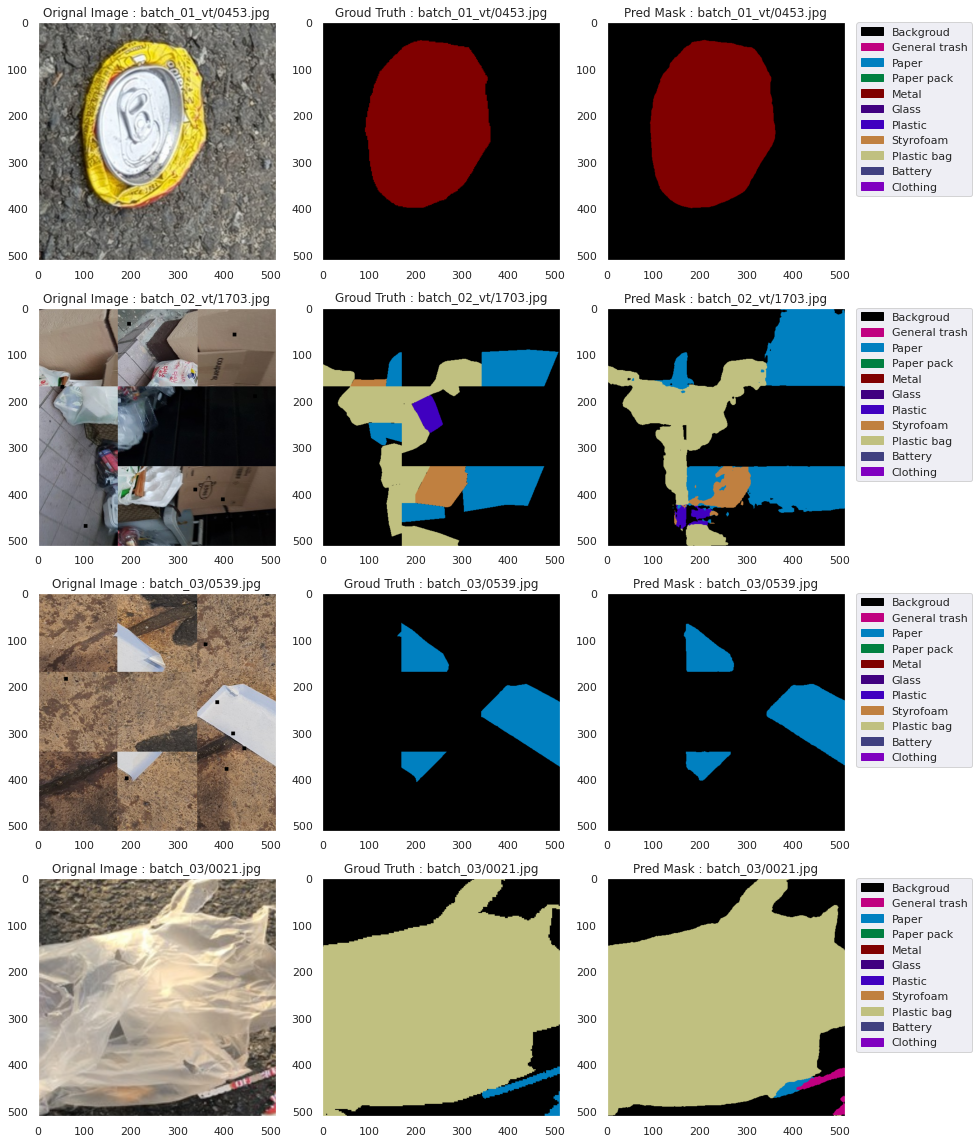

In [113]:
plot_examples(mode="train", batch_id=7, num_examples=4, dataloaer=train_loader)

#### validation set 시각화

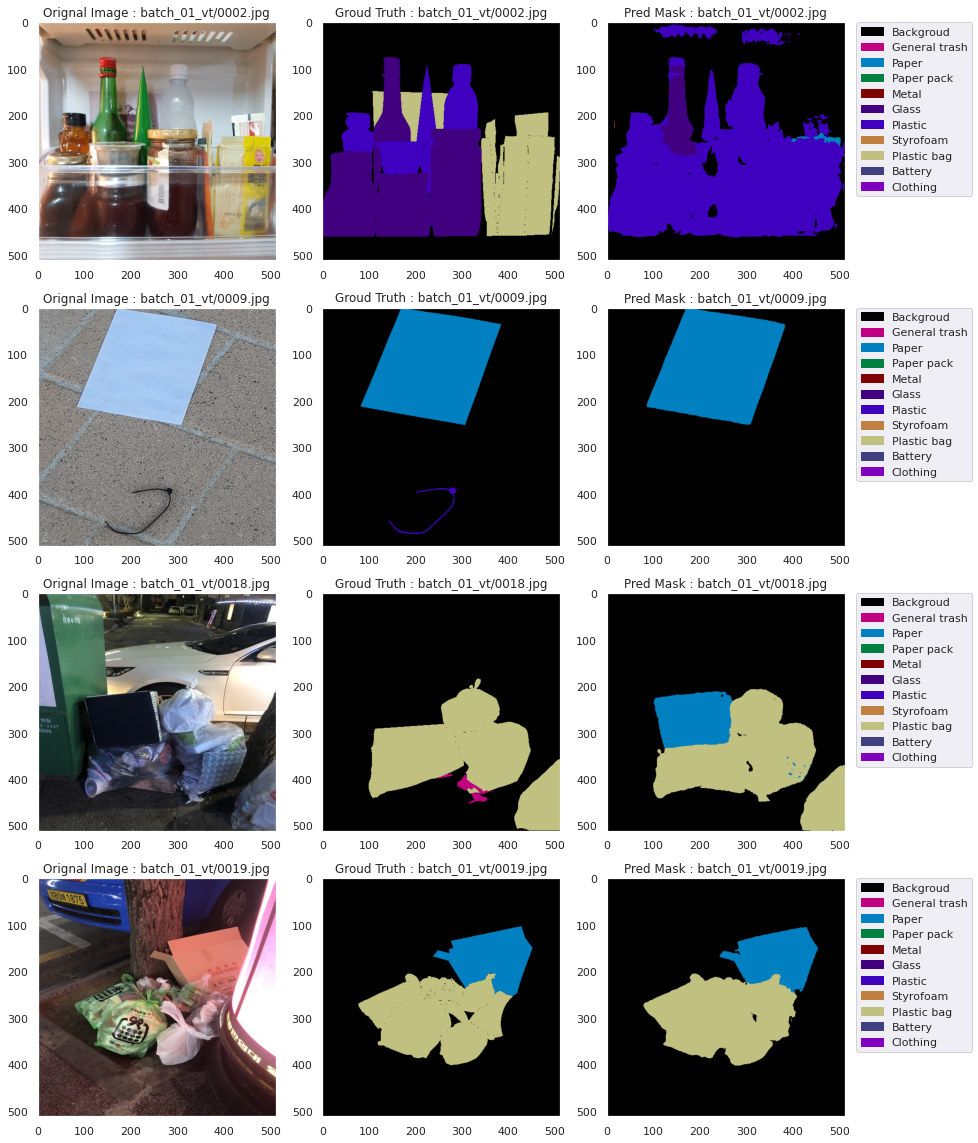

In [114]:
plot_examples(mode="val", batch_id=0, num_examples=4, dataloaer=val_loader)

#### test set 시각화

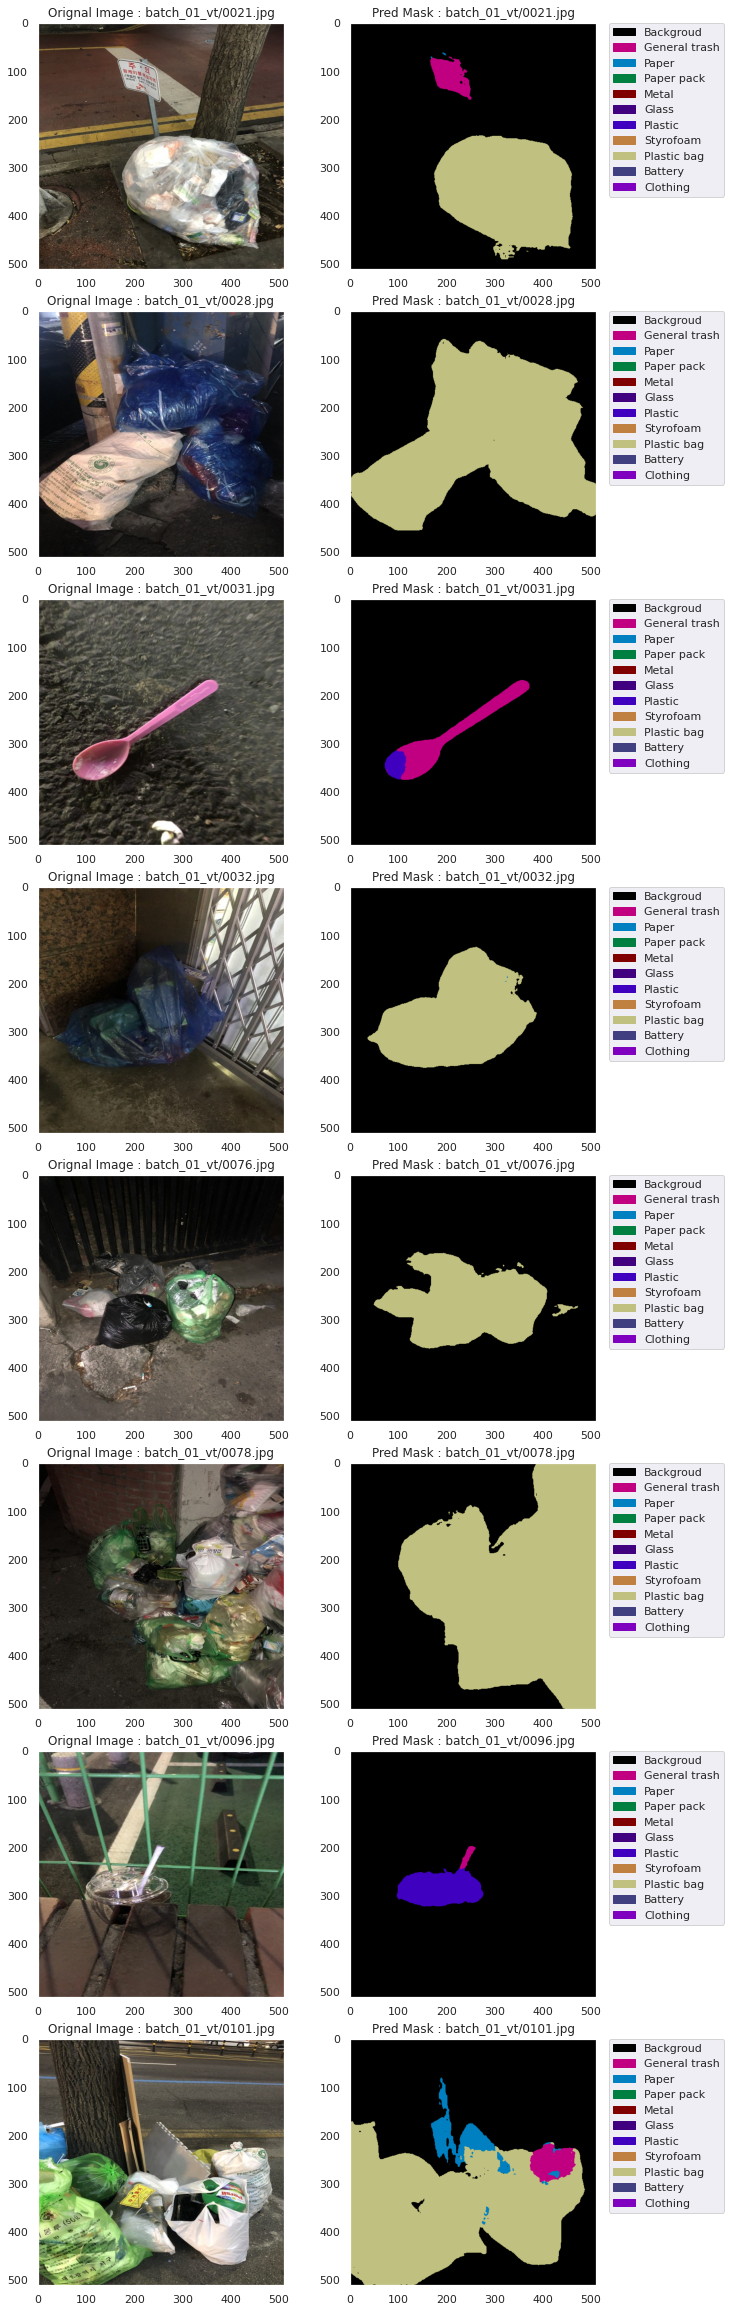

In [115]:
plot_examples(mode="test", batch_id=0, num_examples=8, dataloaer=test_loader)

## submission을 위한 test 함수 정의

In [116]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [117]:
# sample_submisson.csv 열기
submission = pd.read_csv('../submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("../saved/"+CFG['experiment_number']+"/submission.csv", index=False)

Start prediction.


End prediction.
